In [1]:
G_path = './Project_Data'
import pandas as pd
import seaborn as sns
from sklearn import *
import sklearn as sk
from sklearn import *
import numpy as np
from datetime import datetime	
from scipy.stats import chi2_contingency
import datetime as dt
import pickle
import torch
import json
import random
import scipy as sp
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from statistics import mean
import warnings
warnings.filterwarnings('ignore')
import features
from features.usefull_functions import *
from features.NETs import *
from features.Model_Training import *
pd.get_option("display.max_columns")

20

In [2]:
image_label = 'image_label'  #[image_label, binary_label]
select_features = False
remove_All_augmented = False
remove_wrong_cnn_predictions = False

file = 'CNN_280x210_Ouput_MultiClass_SoftMax' #[CNN_280x210_Ouput_MultiClass_SoftMax,CNN_280x210_Ouput_MultiClass_NoSoftMax,CNN_280x210_Ouput_MultiClass_Scaled]

data = pd.read_pickle(G_path + '/07_CNNs_Output_DataSet/' + file)

if remove_All_augmented:
    data = data[~data.image_id.str.contains('AUG')]

blc_test_list = pickle.load(open(G_path + '/02_Augmented_MetaData/balanced_test_set','rb'))
# Evaluation_set = pickle.load(open(G_path + '/DataSet_280x210/' + file,'rb'))


cols_remove = ['image_id','image_label','dx','lesion_id','type','binary_label','label_description']

selected_feature = ['CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6','age','dx_type_consensus','dx_type_follow_up','dx_type_histo']
cnn_ = ['CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6']



train_data = data[data.type=='train']
if remove_wrong_cnn_predictions:

    print('train initial shape: ', train_data.shape)
    train_data['cnn_label'] = train_data[cols].apply(lambda x : np.array(x[cnn_]).argmax(),axis=1)
    train_data = train_data[train_data.cnn_label == train_data.image_label]
    train_data.drop(columns=['cnn_label'],inplace=True)
    print('train removed wrong CNN shape: ',train_data.shape)

valid_data = data[data.type=='valid']
test_data = data[data.type=='test']
blc_test_data = data.merge(blc_test_list['image_id'], how='inner',on='image_id')


train_label = train_data[image_label]
train_data = train_data.drop(columns= cols_remove)
valid_label = valid_data[image_label]
valid_data = valid_data.drop(columns=cols_remove)
test_label = test_data[image_label]
test_data = test_data.drop(columns=cols_remove)
blc_label = blc_test_data[image_label]
blc_data = blc_test_data.drop(columns=cols_remove)

if select_features:
    train_data = train_data[selected_feature]
    valid_data = valid_data[selected_feature]
    test_data = test_data[selected_feature]
    blc_data = blc_test_data[selected_feature]


train_data_arrays = np.stack(train_data.values)  
train_label_arrays = np.stack(train_label.values)
train_label_arrays_One = pd.get_dummies(train_label_arrays).values  

valid_data_arrays = np.stack(valid_data.values)  
valid_label_arrays = np.stack(valid_label.values)  
valid_label_arrays_One = pd.get_dummies(valid_label_arrays).values  

test_data_arrays = np.stack(test_data.values)  
test_label_arrays = np.stack(test_label.values)  
test_label_arrays_One = pd.get_dummies(test_label_arrays).values  

blc_data_arrays = np.stack(blc_data.values)  
blc_label_arrays = np.stack(blc_label.values)  
blc_label_arrays_One = pd.get_dummies(blc_label_arrays).values 

#Numpy Arrays
input_data_Array = (train_data_arrays , valid_data_arrays, test_data_arrays , np.concatenate((train_data_arrays,valid_data_arrays )))
labels_Array = (train_label_arrays,valid_label_arrays,test_label_arrays, np.concatenate((train_label_arrays,valid_label_arrays)))
labels_One_Array = (train_label_arrays_One,valid_label_arrays_One,test_label_arrays_One, np.concatenate((train_label_arrays_One,valid_label_arrays_One)))

# Tensors
def to_Torch(x):
    return torch.tensor(x,dtype= torch.float32)

input_data_Tensor = (to_Torch(train_data_arrays),to_Torch(valid_data_arrays)  , to_Torch(test_data_arrays) , to_Torch(np.concatenate((train_data_arrays,valid_data_arrays))))
labels_Tensor = (to_Torch(train_label_arrays),to_Torch(valid_label_arrays),to_Torch(test_label_arrays) , to_Torch(np.concatenate((train_label_arrays,valid_label_arrays))) )
labels_OneHot_Tensor = (to_Torch(train_label_arrays_One),to_Torch(valid_label_arrays_One),to_Torch(test_label_arrays_One), to_Torch(np.concatenate((train_label_arrays_One,valid_label_arrays_One))))

blc_data_Tensor = (to_Torch(blc_data_arrays))

print('Train set shape: ', train_data_arrays.shape)

Train set shape:  (4993, 30)


In [3]:
Aug_list = data[data.image_id.str.contains('AUG')][['image_id','image_label']]
Aug_list['image_id'] = Aug_list['image_id'].str.replace('AUG1_','').str.replace('AUG2_','').str.replace('AUG3_','')
Aug_list[['image_id','image_label']].value_counts()

image_id      image_label
ISIC_0024318  3              3
ISIC_0029860  0              3
ISIC_0030233  1              3
ISIC_0030244  3              3
ISIC_0030249  1              3
                            ..
ISIC_0027294  0              3
ISIC_0027297  1              3
ISIC_0027303  0              3
ISIC_0027334  0              3
ISIC_0034306  1              3
Length: 580, dtype: int64

In [4]:
id = 'ISIC_0034306'
cols = ['CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6','image_label', 'image_id']
cnn_ = ['CNN_0','CNN_1','CNN_2','CNN_3','CNN_4','CNN_5','CNN_6']
aug_details = data[data.image_id.str.contains(id)][cols]
aug_details['predicted'] = aug_details.apply(lambda x: np.array(x[cnn_]).argmax(),axis=1)
aug_details

,CNN_0,CNN_1,CNN_2,CNN_3,CNN_4,CNN_5,CNN_6,image_label,image_id,predicted
1565,0.001576,0.995705,1.816103e-05,4.860117e-05,1.401287e-05,0.001142,0.001496,1,AUG1_ISIC_0034306,1
2473,0.000442,0.990421,2.428563e-06,1.919965e-07,9.228191e-07,0.000360,0.008773,1,AUG2_ISIC_0034306,1
3366,0.000097,0.958211,1.860994e-05,9.813207e-07,3.309607e-03,0.032399,0.005964,1,ISIC_0034306,1
4052,0.000037,0.999847,2.076089e-07,6.701777e-06,4.041554e-07,0.000038,0.000070,1,AUG3_ISIC_0034306,1


In [186]:
train_label_arrays, train_data['CNN_0'].max() , input_data_Array[0].shape

(array([2, 1, 1, ..., 4, 3, 5], dtype=int8), 20.283476, (4993, 30))

# **Guassian NB**

In [5]:
Model_ = sk.naive_bayes.GaussianNB()
# kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
kflods = sk.model_selection.StratifiedKFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = False
nr_repeat = 2

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'priors': [None],
    'var_smoothing': [0,4e-1,5e-1,3e-1, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]
}

GB_Model, GB_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(GB_Model, open(G_path + '/Saved/Models/Classifiers/' + 'GB_Model' , 'wb'))

 Max_Valid_Acc.: 90.6%, Max_Test_Acc.: 69.0%, Expected_test_Acc.: 68.8% [██████████████████████████████] 341/340 [Time => Iter.: 0.0s, Tot.: 2.7s, Remain.: -0.0s]     Remain.: 0.0s]    
------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.38      0.43      0.41        23
           1       0.42      0.78      0.55        32
           2       0.62      0.44      0.52        72
           3       0.67      0.50      0.57         8
           4       0.49      0.61      0.55        62
           5       0.91      0.81      0.86       200
           6       1.00      0.80      0.89        10

    accuracy                           0.69       407
   macro avg       0.64      0.63      0.62       407
weighted avg       0.72      0.69      0.70       407

Best param:  {'priors': None, 'var_smoothing': 0.3}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.687960687960688


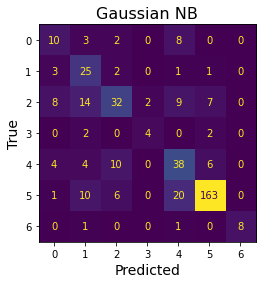

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,38.5%,43.5%,95.8%,40.8%
1,7.9%,42.4%,78.1%,90.9%,54.9%
2,17.7%,61.5%,44.4%,94.0%,51.6%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,49.4%,61.3%,88.7%,54.7%
5,49.1%,91.1%,81.5%,92.3%,86.0%
6,2.5%,100.0%,80.0%,100.0%,88.9%
Simple Avg.,nan%,64.2%,62.7%,94.5%,62.0%
Weighted Avg.,nan%,72.4%,68.8%,92.5%,69.7%


In [6]:
# Model 280x210
model_ = GB_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'Gaussian NB')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

In [8]:
recall_specificity_precision_fscore(Y,Y_pred,weighted_avg=True)

(0.688, 0.925, 0.724)

**Cross Validation**

In [ ]:
Model_ = sk.naive_bayes.GaussianNB()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_mode = False
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'priors': [None],
    'var_smoothing': [5e-1]
}

GB_Model_CV, GB_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=10)

if save_model:
    pickle.dump(GB_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'GB_Model_CV' , 'wb'))
    pickle.dump(GB_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'GB_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.50      0.52      0.51        23
           1       0.49      0.69      0.57        32
           2       0.66      0.46      0.54        72
           3       1.00      0.38      0.55         8
           4       0.43      0.52      0.47        62
           5       0.81      0.83      0.82       200
           6       1.00      0.50      0.67        10

    accuracy                           0.67       407
   macro avg       0.70      0.56      0.59       407
weighted avg       0.69      0.67      0.67       407

Best param:  {'priors': None, 'var_smoothing': 0.5}


# **Random Forrest**

In [145]:
Model_ = sk.ensemble.RandomForestClassifier( n_jobs=-1)
# kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
kflods = sk.model_selection.StratifiedKFold(n_splits=10, shuffle=True)

cross_valid = False
save_model = False
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_estimators': [200],
    'max_features': ['auto', 'log2'],
    'max_depth' : [30,40],
    'min_samples_leaf': [2, 5,10],
    'criterion' :['gini', 'entropy'],
    'bootstrap': [False],
    'class_weight' : [None, 'balanced'],
    'max_leaf_nodes' : [None],
    'max_features' : ['log2', None]
}
# grid = { 
#     'n_estimators': [200,400],
#     'max_features': ['auto'],
#     'max_depth' : [40],
#     'min_samples_leaf': [10],
#     'criterion' :['gini'],
#     'bootstrap': [False],
#     'class_weight' : ['balanced'],
#     'max_leaf_nodes' : [None],
#     'max_features' : ['log2']
# }

RF_Model, RF_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

date_hour = datetime.now().strftime("%d_%b%y_%H_%M")
if save_model:
    pickle.dump(RF_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'RF_Model_' + date_hour , 'wb'))

 Max_Valid_Acc.: 75.7%, Max_Test_Acc.: 71.7%, Expected_test_Acc.: 70.5% [██████████████████████████████] 49/48 [Time => Iter.: 1.3s, Tot.: 30.8s, Remain.: -0.6s]    
------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.42      0.48      0.45        23
           1       0.53      0.72      0.61        32
           2       0.57      0.61      0.59        72
           3       0.60      0.38      0.46         8
           4       0.55      0.52      0.53        62
           5       0.88      0.82      0.85       200
           6       0.90      0.90      0.90        10

    accuracy                           0.71       407
   macro avg       0.64      0.63      0.63       407
weighted avg       0.72      0.71      0.71       407

Best param:  {'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 40, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_samples_leaf': 2, 'n_estimators': 200}


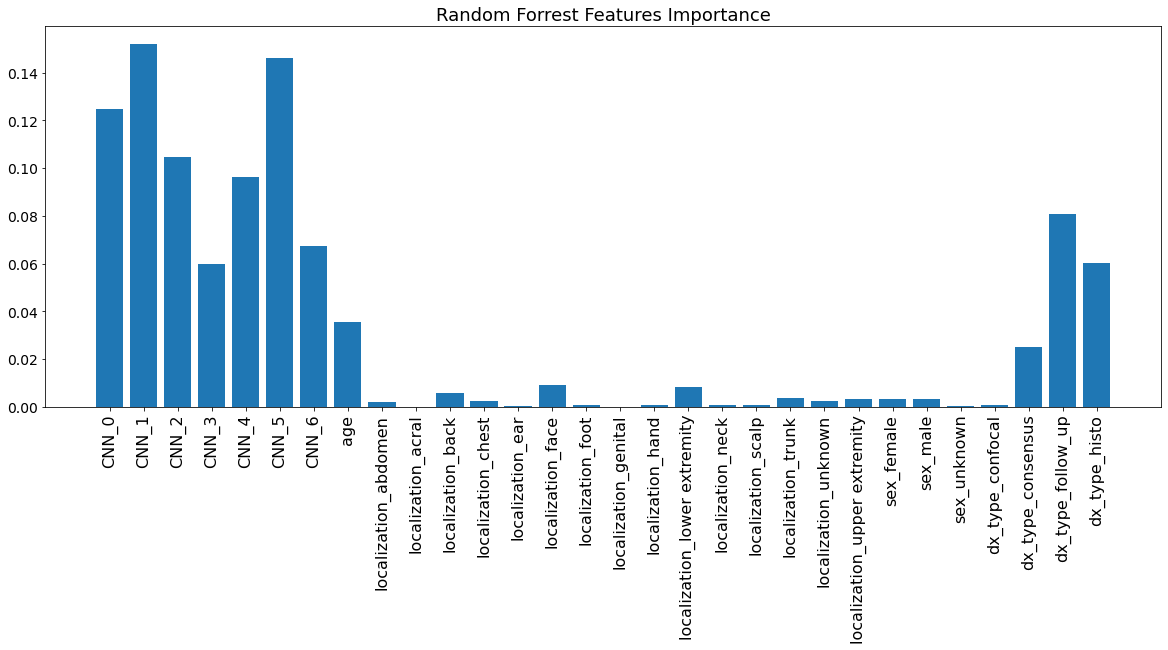

In [34]:
importance = RF_Model.feature_importances_

features_name = list(train_data.columns)
plt.subplots(figsize=(20,7))
plt.bar(features_name, importance)
plt.xticks(fontsize=16, rotation=90)
plt.title('Random Forrest Features Importance',fontsize = 18)
plt.show()

Nr. of Data : 
 407
Accuracy of The Model : 
 0.7076167076167076


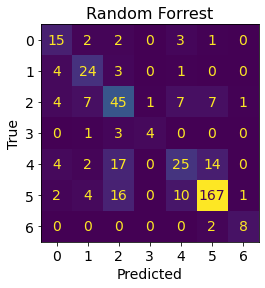

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,51.7%,65.2%,96.4%,57.7%
1,7.9%,60.0%,75.0%,95.7%,66.7%
2,17.7%,52.3%,62.5%,87.8%,57.0%
3,2.0%,80.0%,50.0%,99.7%,61.5%
4,15.2%,54.3%,40.3%,93.9%,46.3%
5,49.1%,87.4%,83.5%,88.4%,85.4%
6,2.5%,80.0%,80.0%,99.5%,80.0%
Simple Avg.,nan%,66.5%,65.2%,94.5%,64.9%
Weighted Avg.,nan%,71.7%,70.8%,90.7%,70.8%


In [58]:
# Model 280x210
model_ = RF_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_pred_prob = model_.predict_proba(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'Random Forrest')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

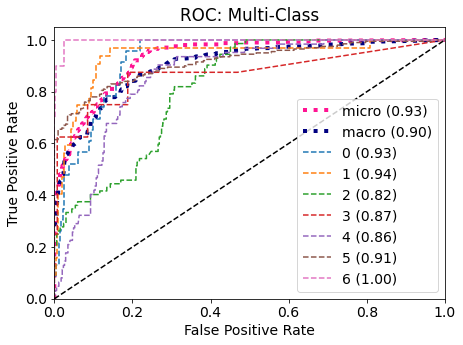

In [29]:
Y_OneH = sk.preprocessing.label_binarize(Y,classes=np.unique(Y))
fpr, tpr, roc_auc = fpr_tpr_score(Y_OneH,Y_pred_prob)
plot_roc_auc_multi(fpr, tpr, roc_auc)

**Cross Validation**

In [13]:
Model_ = sk.ensemble.RandomForestClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = False
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [20],
    'criterion' :['gini'],
    'bootstrap': [False],
    'class_weight' : [None,],
    'max_leaf_nodes' : [None],
}

RF_Model_CM, RF_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(RF_Model_CM, open(G_path + '/Saved/Models/Classifiers/' + 'RF_Model_CV' , 'wb'))
    pickle.dump(RF_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'RF_Model_CV' , 'wb'))


------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.50      0.70      0.58        23
           1       0.56      0.69      0.62        32
           2       0.64      0.67      0.65        72
           3       0.67      0.50      0.57         8
           4       0.58      0.45      0.51        62
           5       0.88      0.87      0.88       200
           6       0.90      0.90      0.90        10

    accuracy                           0.74       407
   macro avg       0.68      0.68      0.67       407
weighted avg       0.74      0.74      0.74       407

Best param:  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'auto', 'max_leaf_nodes': None, 'n_estimators': 200}


In [14]:
RF_Details_CV.shape

(100, 11)

# **SVM**

In [59]:
Model_ = sk.svm.SVC(random_state=0)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = False
save_model = False
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'C' : [8,10,12]
    ,'kernel': ['rbf', 'linear'],
    'degree' : [1,3],
    'gamma' :['scale', 'auto'],
    'decision_function_shape': ['ovo', 'ovr'],
    'class_weight' : [None, 'balanced']
}

SVM_Model, SVM_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(SVM_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'SVM_Model' , 'wb'))
    

 Max_Valid_Acc.: 75.4%, Max_Test_Acc.: 73.7%, Expected_test_Acc.: 72.7% [██████████████████████████████] 97/96 [Time => Iter.: 0.1s, Tot.: 13.6s, Remain.: -0.1s]    
------- Precision recal %--------
              precision    recall  f1-score   support

           0       0.50      0.74      0.60        23
           1       0.65      0.75      0.70        32
           2       0.56      0.62      0.59        72
           3       0.83      0.62      0.71         8
           4       0.57      0.44      0.50        62
           5       0.88      0.85      0.87       200
           6       0.80      0.80      0.80        10

    accuracy                           0.73       407
   macro avg       0.69      0.69      0.68       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'C': 8, 'class_weight': None, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.7199017199017199


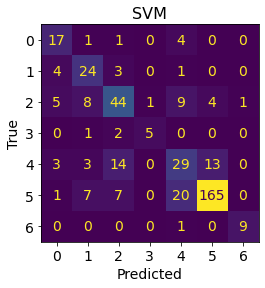

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,56.7%,73.9%,96.6%,64.2%
1,7.9%,54.5%,75.0%,94.7%,63.2%
2,17.7%,62.0%,61.1%,91.9%,61.5%
3,2.0%,83.3%,62.5%,99.7%,71.4%
4,15.2%,45.3%,46.8%,89.9%,46.0%
5,49.1%,90.7%,82.5%,91.8%,86.4%
6,2.5%,90.0%,90.0%,99.7%,90.0%
Simple Avg.,nan%,68.9%,70.3%,94.9%,69.0%
Weighted Avg.,nan%,73.8%,72.0%,92.4%,72.6%


In [43]:
# Model 280x210
model_ = SVM_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'SVM')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [14]:
Model_ = sk.svm.SVC(random_state=0)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = False
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'C' : [10]
    ,'kernel': ['rbf'],
    'degree' : [1],
    'gamma' :['scale'],
    'decision_function_shape': ['ovo'],
    'class_weight' : [None]
}

SVM_Model_CV, SVM_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(SVM_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'SVM_Model_CV' , 'wb'))
    pickle.dump(SVM_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'SVM_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.50      0.65      0.57        23
           1       0.54      0.69      0.60        32
           2       0.66      0.68      0.67        72
           3       0.67      0.50      0.57         8
           4       0.54      0.44      0.48        62
           5       0.88      0.85      0.87       200
           6       0.82      0.90      0.86        10

    accuracy                           0.73       407
   macro avg       0.66      0.67      0.66       407
weighted avg       0.73      0.73      0.73       407

Best param:  {'C': 10, 'class_weight': None, 'decision_function_shape': 'ovo', 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


# **MLP**

In [1]:
Model_ = sk.neural_network.MLPClassifier()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = False
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {
    'hidden_layer_sizes': [(50,60,50),(40,60,30)],
    'random_state':[0],
    'activation': [ 'relu'],
    'solver': ['sgd',],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : 10.00 ** -np.arange(2, 4)
}

MLP_Model, MLP_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)
if save_model:
    pickle.dump(MLP_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'MLP_Model' , 'wb'))
    

NameError: name 'sk' is not defined

Nr. of Data : 
 407
Accuracy of The Model : 
 0.7272727272727273


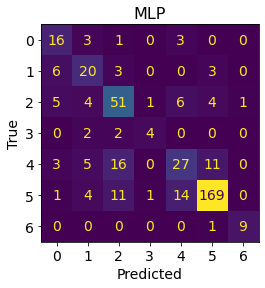

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,51.6%,69.6%,96.1%,59.3%
1,7.9%,52.6%,62.5%,95.2%,57.1%
2,17.7%,60.7%,70.8%,90.1%,65.4%
3,2.0%,66.7%,50.0%,99.5%,57.1%
4,15.2%,54.0%,43.5%,93.3%,48.2%
5,49.1%,89.9%,84.5%,90.8%,87.1%
6,2.5%,90.0%,90.0%,99.7%,90.0%
Simple Avg.,nan%,66.5%,67.3%,95.0%,66.3%
Weighted Avg.,nan%,73.7%,72.7%,92.1%,72.9%


In [19]:
# Model 280x210
model_ = MLP_Model
X = input_data_Array[2]
Y = labels_Array[2]
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'MLP')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [20]:
Model_ = sk.neural_network.MLPClassifier()
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {
    'hidden_layer_sizes': [(50,60,50)],
    'random_state':[0],
    'activation': [ 'relu'],
    'solver': ['sgd',],
    'alpha': [0.0001],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : [1e-2]
}

MLP_Model_CV, MLP_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)
if save_model:
    pickle.dump(MLP_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'MLP_Model_CV' , 'wb'))
    pickle.dump(MLP_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'MLP_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.55      0.70      0.62        23
           1       0.52      0.69      0.59        32
           2       0.67      0.64      0.65        72
           3       0.67      0.50      0.57         8
           4       0.52      0.48      0.50        62
           5       0.89      0.85      0.87       200
           6       0.90      0.90      0.90        10

    accuracy                           0.73       407
   macro avg       0.67      0.68      0.67       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 60, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.01, 'random_state': 0, 'solver': 'sgd'}


# **KNN**

In [21]:
Model_ = neighbors.KNeighborsClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 1

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_neighbors': [7,8,12],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto','ball_tree','kd_tree','brute'],
    'leaf_size' : [20,25],
    'p' : [1,2,5]
}

KNN_Model, KNN_Details = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(KNN_Model, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'KNN_Model' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 1440/1440
              precision    recall  f1-score   support

           0       0.42      0.57      0.48        23
           1       0.64      0.66      0.65        32
           2       0.65      0.74      0.69        72
           3       0.71      0.62      0.67         8
           4       0.52      0.55      0.53        62
           5       0.92      0.83      0.87       200
           6       1.00      0.70      0.82        10

    accuracy                           0.73       407
   macro avg       0.69      0.67      0.67       407
weighted avg       0.76      0.73      0.74       407

Best param:  {'algorithm': 'brute', 'leaf_size': 25, 'n_neighbors': 8, 'p': 1, 'weights': 'uniform'}


Nr. of Data : 
 407
Accuracy of The Model : 
 0.7346437346437347


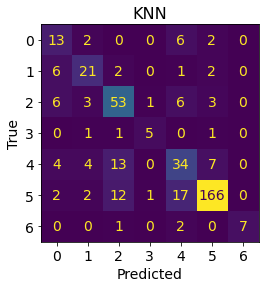

,weights,Precision,Recall_Sensitivity,Specificity,f1_score
0,5.7%,41.9%,56.5%,95.3%,48.1%
1,7.9%,63.6%,65.6%,96.8%,64.6%
2,17.7%,64.6%,73.6%,91.3%,68.8%
3,2.0%,71.4%,62.5%,99.5%,66.7%
4,15.2%,51.5%,54.8%,90.7%,53.1%
5,49.1%,91.7%,83.0%,92.8%,87.1%
6,2.5%,100.0%,70.0%,100.0%,82.4%
Simple Avg.,nan%,69.3%,66.6%,95.2%,67.3%
Weighted Avg.,nan%,75.6%,73.5%,93.0%,74.2%


In [22]:
# Model 280x210
model_ = KNN_Model
X = input_data_Array[2]
Y = labels_Array[2]
# X = blc_data_arrays
# Y = blc_label_arrays
Y_pred = model_.predict(X)
Y_binary =  label_to_binary(Y)
Y_pred_binary =  label_to_binary(Y_pred)
results = model_evaluation(Y,Y_pred,'KNN')
# results = model_evaluation(Y_binary,Y_pred_binary)
results

**Cross Validation**

In [23]:
Model_ = neighbors.KNeighborsClassifier(n_jobs=-1)
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = { 
    'n_neighbors': [8],
    'weights': ['distance'],
    'algorithm': ['auto'],
    'leaf_size' : [25],
    'p' : [2]
}

KNN_Model_CV, KNN_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(KNN_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'KNN_Model_CV' , 'wb'))
    pickle.dump(KNN_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'KNN_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.38      0.52      0.44        23
           1       0.61      0.59      0.60        32
           2       0.68      0.74      0.71        72
           3       0.71      0.62      0.67         8
           4       0.48      0.47      0.48        62
           5       0.89      0.85      0.87       200
           6       1.00      0.90      0.95        10

    accuracy                           0.73       407
   macro avg       0.68      0.67      0.67       407
weighted avg       0.74      0.73      0.73       407

Best param:  {'algorithm': 'auto', 'leaf_size': 25, 'n_neighbors': 8, 'p': 2, 'weights': 'distance'}


# **Biased Classifier**

In [24]:
Dum_class = sk.dummy.DummyClassifier(strategy="most_frequent" )

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

Dum_class.fit(X_train, Y_train)

Y = Y_test
Y_pred = Dum_class.predict(X_test)

print(sk.metrics.classification_report(Y,Y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        62
           5       0.49      1.00      0.66       200
           6       0.00      0.00      0.00        10

    accuracy                           0.49       407
   macro avg       0.07      0.14      0.09       407
weighted avg       0.24      0.49      0.32       407



In [25]:
test_recall_weighed, test_specificity_weighed, _ = recall_specificity_precision(Y,Y_pred,weighted_avg=True)

In [26]:
Model_ = sk.dummy.DummyClassifier(strategy="most_frequent" )
kflods = sk.model_selection.KFold(n_splits=10, shuffle=True)
cross_valid = True
save_model = True
nr_repeat = 10

X_train = input_data_Array[0]
Y_train = labels_Array[0]
X_valid = input_data_Array[1]
Y_valid = labels_Array[1]
X_test = input_data_Array[2]
Y_test = labels_Array[2]

grid = {}

Biased_Model_CV, Biased_Details_CV = grid_searc_cross_valid_trainer(Model_, grid, cross_valid, kflods,X_train=X_train , Y_train=Y_train,X_valid=X_valid,Y_valid=Y_valid,X_test=X_test, Y_test=Y_test,nr_repeat=nr_repeat)

if save_model:
    pickle.dump(Biased_Model_CV, open(G_path + '/08_Saved_Models_Outpus/Models/Classifiers/' + 'Biased_Model_CV' , 'wb'))
    pickle.dump(Biased_Details_CV, open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'Biased_Model_CV' , 'wb'))

------- Precision recal %--------█████████████████████████████████████████████████████████████████████████████████] 100/100
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.00      0.00      0.00        32
           2       0.00      0.00      0.00        72
           3       0.00      0.00      0.00         8
           4       0.00      0.00      0.00        62
           5       0.49      1.00      0.66       200
           6       0.00      0.00      0.00        10

    accuracy                           0.49       407
   macro avg       0.07      0.14      0.09       407
weighted avg       0.24      0.49      0.32       407

Best param:  {}


In [27]:
CNN_Rescaled_Details = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'CNN_Rescaled_Details_MultiClass' ,'rb'))
CNN_A_E_Details = pickle.load(open(G_path + '/08_Saved_Models_Outpus/Cross_Valid_Results/' + 'CNN_A_E_Details_MultiClass' ,'rb'))

In [28]:
c = 'test_recall_weighed'
df = [CNN_A_E_Details,CNN_Rescaled_Details,RF_Details_CV,SVM_Details_CV,MLP_Details_CV,GB_Details_CV,KNN_Details_CV,Biased_Details_CV]
clss_name = ['CNN-A.E.','CNN-Resc.','RF','SVM','MLP','GB','KNN','Biased']
df_0 = pd.DataFrame()
for i in range(0, len(df)):
    df_00 = pd.DataFrame(df[i][c].values, columns=[clss_name[i]])
    df_0 = pd.concat([df_0,df_00],axis=1)

Sensitivity = df_0

In [33]:
c = 'test_recall_weighed'
x = list(RF_Details_CV[c])
y = list(GB_Details_CV[c])
from scipy.stats.mstats import f_oneway
f, p = f_oneway(x, y)
print("Anova's p-value = ", p)
print("Anova's f = ", f)

eff_size = (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x) ** 2 + np.std(y) ** 2) / 2.0)
eff_size

Anova's p-value =  1.9755432751551668e-143
Anova's f =  5118.305657649242


10.168584675160066

In [31]:
len(y)

10

In [36]:

(t, p) = sp.stats.wilcoxon(x, y)
t, p

(0.0, 3.679402088127131e-18)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


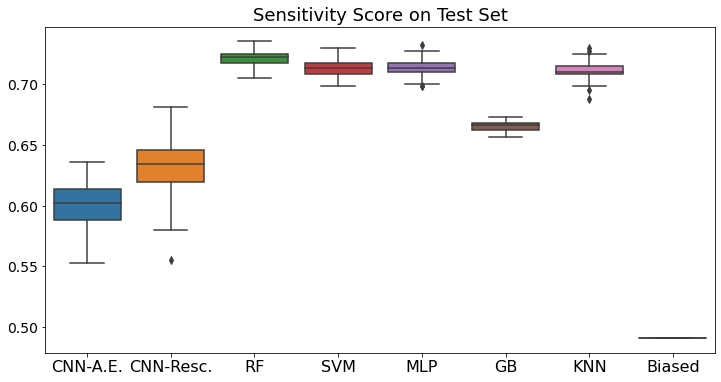

In [29]:
plt.subplots(figsize=(12,6))
sns.boxplot(data=Sensitivity)
plt.title('Sensitivity Score on Test Set',fontsize = 18)
# plt.xlabel("Classifiers", fontsize = 14)
# plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()

In [30]:
c = 'test_specificity_weighed'
df = [CNN_A_E_Details,CNN_Rescaled_Details,RF_Details_CV,SVM_Details_CV,MLP_Details_CV,GB_Details_CV,KNN_Details_CV,Biased_Details_CV]
clss_name = ['CNN-A.E.','CNN-Resc.','RF','SVM','MLP','GB','KNN','Biased']
df_0 = pd.DataFrame()
for i in range(0, len(df)):
    df_00 = pd.DataFrame(df[i][c].values, columns=[clss_name[i]])
    df_0 = pd.concat([df_0,df_00],axis=1)

specificity = df_0

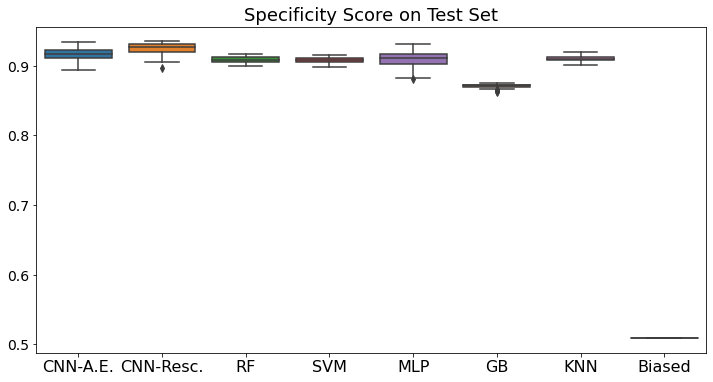

In [31]:
plt.subplots(figsize=(12,6))
sns.boxplot(data=specificity)
plt.title('Specificity Score on Test Set',fontsize = 18)
# plt.xlabel("Classifiers", fontsize = 14)
# plt.ylabel("Accuracy", fontsize = 14)
plt.xticks(fontsize=16, rotation=0)
plt.show()